This notebook is a first attempt at seeing:

- how many molecules we have MS2's for, and
- the distribution of chemical classes of these molecules

In [41]:
import pandas as pd
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# User-defined modules
import os, sys
src_dir = os.path.normpath('../util')
sys.path.insert(0, src_dir)
import util

In [8]:
reload(util)

<module 'util' from '../util/util.py'>

In [9]:
# Read in the csv data
fname = '../../data/clean/metabolites_and_spectra.csv'
all_mtabs = util.unpackCSV(fname)

In [10]:
# Count the number of metabolites which have MS2's
mtabs_ms2 = {k: all_mtabs[k] for k in all_mtabs if len(all_mtabs[k].MS2) > 0}
print('Of the {} metabolites in HMDB, {} have at least one MS2'.format(len(all_mtabs), len(mtabs_ms2)))

Of the 74234 metabolites in HMDB, 865 have at least one MS2


In [27]:
# Make tidy dataframe with [inchi, hmdb_id, all-taxonomy-levels, ms2_id, npeaks, ionization]
taxa_cols = ['kingdom', 'super_class', 'sub_class', 'class', 'molecular_framework']
empty_tax_dict = {i: '' for i in taxa_cols}
dflst = []
for m in all_mtabs:
    mtab = all_mtabs[m]
    n_ms2 = len(mtab.MS2)
    if n_ms2 > 0:
        hmdb_id = mtab.accession
        taxonomy = mtab.taxonomy_dict
        if taxonomy is None:
            taxonomy = empty_tax_dict
        m_lst = [m, hmdb_id] + [taxonomy[t] for t in taxa_cols]

        for i in range(n_ms2):
            npeaks = mtab.MS2[i].peak_counter
            ionization = mtab.MS2[i].ionization_mode
            
            if npeaks is not None:
                npeaks = int(npeaks)
            else:
                npeaks = np.nan
            if ionization is None:
                ionization = np.nan

            dflst.append(m_lst + [i, npeaks, ionization])

In [35]:
df = pd.DataFrame(dflst, 
                  columns=['inchi', 'hmdb'] + taxa_cols + ['ms2_counter', 'npeaks', 'ionization'])

In [36]:
df.head()

,inchi,hmdb,kingdom,super_class,sub_class,class,molecular_framework,ms2_counter,npeaks,ionization
0,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,0,1.0,Positive
1,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,1,20.0,Positive
2,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,2,12.0,Positive
3,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,3,194.0,Positive
4,ZQSIJRDFPHDXIC-UHFFFAOYSA-N,HMDB0003312,Organic compounds,Phenylpropanoids and polyketides,Isoflav-2-enes,Isoflavonoids;,Aromatic heteropolycyclic compounds,4,218.0,Positive


In [44]:
# First: what's the distribution of classes?
for tax in taxa_cols:
    display(df[['inchi', 'hmdb'] + taxa_cols].drop_duplicates().groupby(tax).size().sort_values(ascending=False))

kingdom
Chemical entities    549
Organic compounds    316
dtype: int64

super_class
Organic compounds                          540
Lipids and lipid-like molecules             90
Organic acids and derivatives               55
Organoheterocyclic compounds                45
Organic oxygen compounds                    43
Benzenoids                                  41
Phenylpropanoids and polyketides            16
Organic nitrogen compounds                  14
Inorganic compounds                          9
Nucleosides, nucleotides, and analogues      6
Organosulfur compounds                       5
Hydrocarbons                                 1
dtype: int64

sub_class
Carboxylic acids and derivatives                127
Fatty Acyls                                      72
Organooxygen compounds                           63
Amino acids, peptides, and analogues             34
Benzene and substituted derivatives              30
Fatty acids and conjugates                       20
Imidazopyrimidines                               20
Carbohydrates and carbohydrate conjugates        20
                                                 19
Phenols                                          18
Indoles and derivatives                          17
Organonitrogen compounds                         16
Hydroxy acids and derivatives                    15
Benzoic acids and derivatives                    15
Keto acids and derivatives                       13
Purine nucleotides                               13
Carbonyl compounds                               12
Bile acids, alcohols and derivatives             11
Alcohols and polyols                             11
St

class
Organic acids and derivatives;               170
Lipids and lipid-like molecules;              95
Organoheterocyclic compounds;                 72
Organic oxygen compounds;                     63
Benzenoids;                                   51
Nucleosides, nucleotides, and analogues;      47
Steroids and steroid derivatives;             45
Carboxylic acids and derivatives;             43
Organooxygen compounds;                       43
Fatty Acyls;                                  30
Benzene and substituted derivatives;          28
Phenylpropanoids and polyketides;             22
Organic nitrogen compounds;                   16
Organonitrogen compounds;                     14
Prenol lipids;                                13
Pyridines and derivatives;                    10
Phenols;                                      10
Homogeneous non-metal compounds;               9
Imidazopyrimidines;                            6
Indoles and derivatives;                       6
Flavonoids;   

molecular_framework
Aliphatic acyclic compounds             363
Aromatic homomonocyclic compounds       138
Aromatic heteropolycyclic compounds     120
Aromatic heteromonocyclic compounds      80
Aliphatic heteromonocyclic compounds     70
Aliphatic homopolycyclic compounds       46
Aliphatic homomonocyclic compounds       20
Aromatic homopolycyclic compounds        15
                                          9
Aliphatic heteropolycyclic compounds      4
dtype: int64

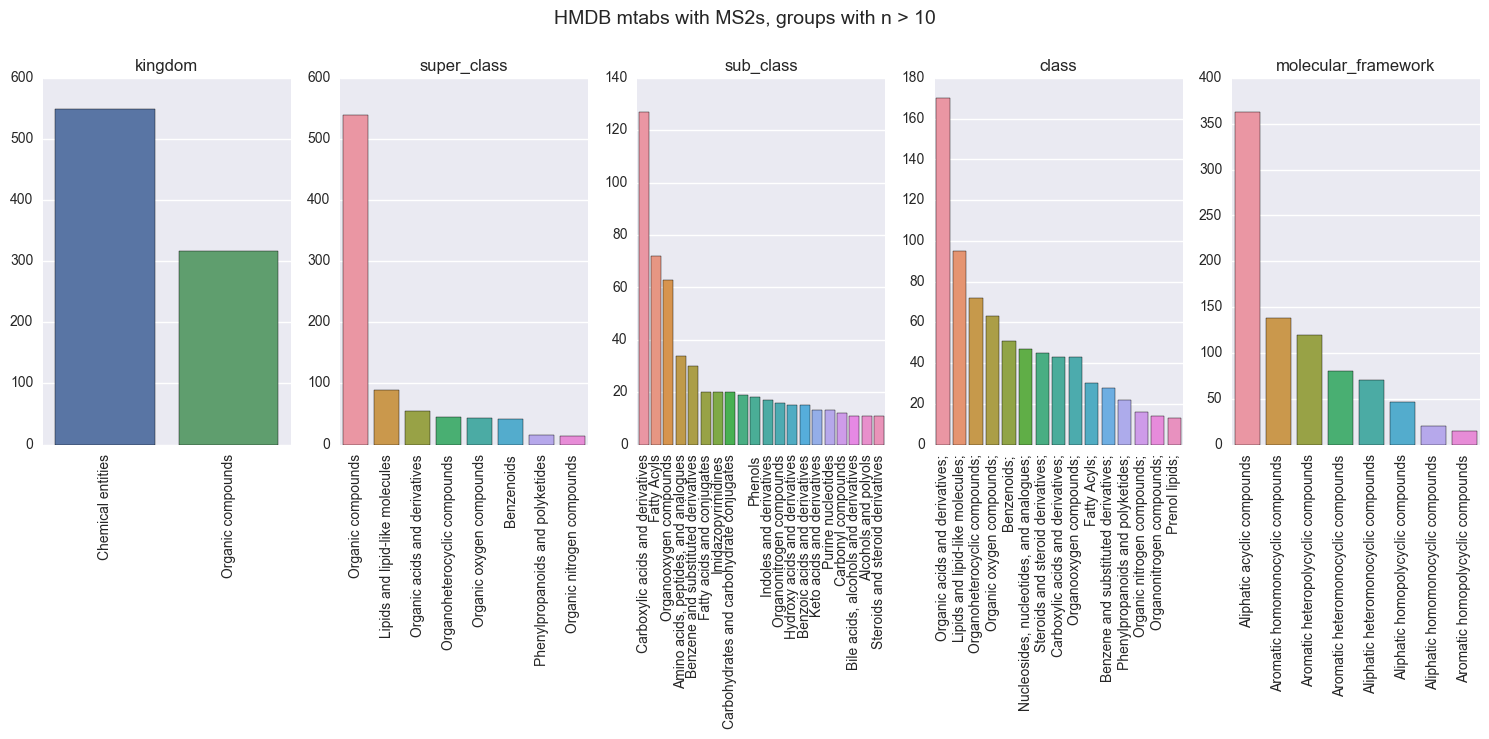

In [110]:
fig, ax = plt.subplots(1, 5, figsize=(15, 7))
i = 0
nodups_df = df[['inchi', 'hmdb'] + taxa_cols].drop_duplicates()
for t in taxa_cols:
    toplot = nodups_df.groupby(t).size().sort_values(ascending=False).reset_index()
    toplot.columns = [t, 'n_compounds']
    toplot = toplot.query('n_compounds > 10')
    sns.barplot(x=t, y="n_compounds", data=toplot, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    ax[i].set_xlabel('')
    ax[i].set_title(t)
    i += 1
fig.suptitle('HMDB mtabs with MS2s, groups with n > 10', fontsize=14, y=1.05)
fig.tight_layout()
fig.savefig('class_distributions.hmdb_with_ms2.min_group_10.png')

Hm... these numbers are pretty low. Especially would have liked to be able to build a classifier for bile acids!! But there are only 20 or so...

# What's the distribution in all of HMDB, regardless of MS2 availability?

In [90]:
# Make tidy dataframe with [inchi, hmdb_id, all-taxonomy-levels, n_ms2]
taxa_cols = ['kingdom', 'super_class', 'sub_class', 'class', 'molecular_framework']
empty_tax_dict = {i: '' for i in taxa_cols}
hmdbdflst = []
for m in all_mtabs:
    mtab = all_mtabs[m]
    n_ms2 = len(mtab.MS2)
    hmdb_id = mtab.accession
    taxonomy = mtab.taxonomy_dict
    if taxonomy is None:
        taxonomy = empty_tax_dict
    m_lst = [m, hmdb_id] + [taxonomy[t] for t in taxa_cols] + [n_ms2]

    hmdbdflst.append(m_lst)

In [91]:
hmdb_df = pd.DataFrame(hmdbdflst, columns=['inchi', 'hmdb'] + taxa_cols + ['n_ms2'])

In [93]:
hmdb_df.shape

(74234, 8)

In [96]:
hmdb_df[['inchi', 'hmdb', 'kingdom']].drop_duplicates().shape

(74234, 3)

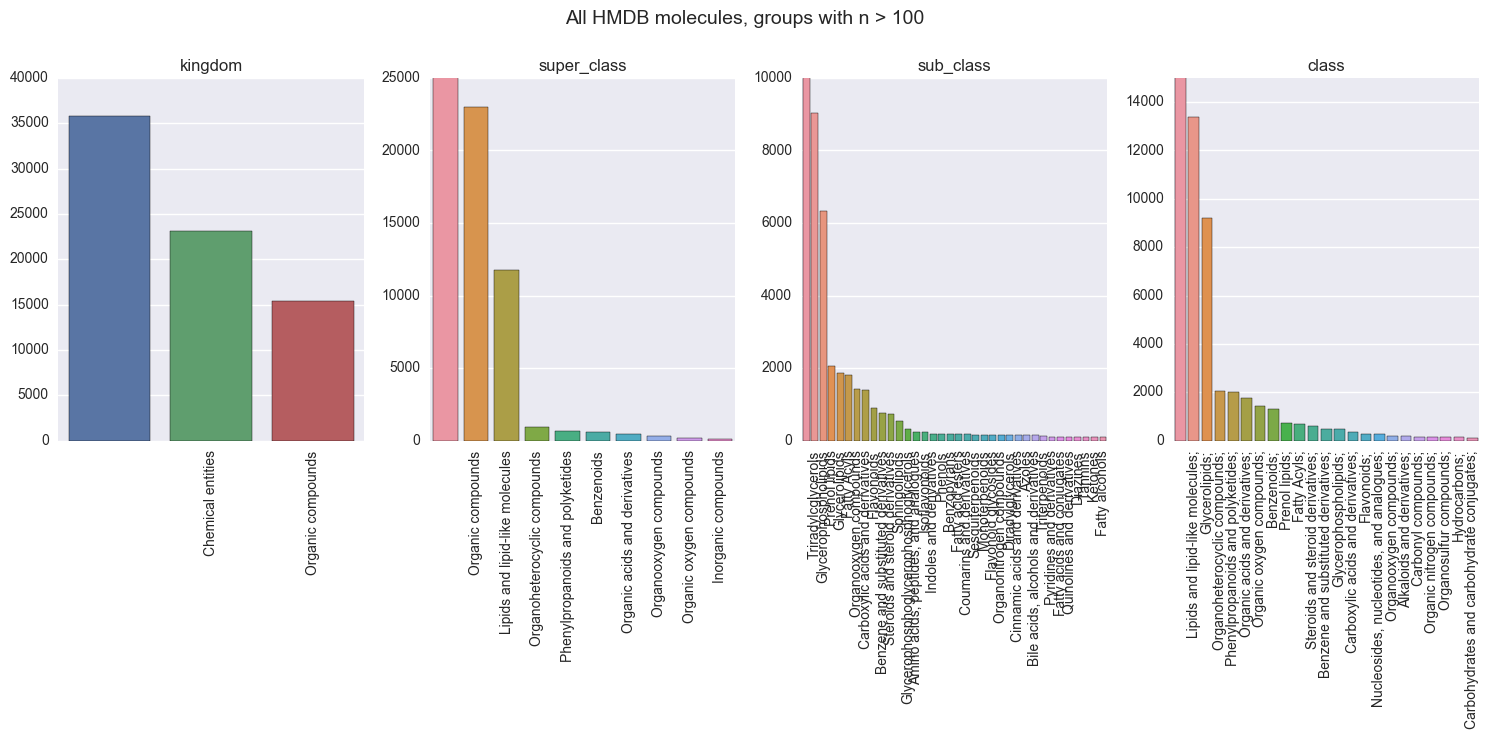

In [114]:
ylims = {0: None, 1: 25000, 2: 10000, 3: 15000}
fig, ax = plt.subplots(1, 4, figsize=(15, 7))
i = 0
for t in taxa_cols[:-1]:
    toplot = hmdb_df.groupby(t).size().sort_values(ascending=False).reset_index()
    toplot.columns = [t, 'n_compounds']
    toplot = toplot.query('n_compounds > 100')
    sns.barplot(x=t, y="n_compounds", data=toplot, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    ax[i].set_xlabel('')
    ax[i].set_title(t)
    ax[i].set_ylim([0, ylims[i]])
    i += 1
fig.suptitle('All HMDB molecules, groups with n > 100', fontsize=14, y=1.05)
fig.tight_layout()
fig.savefig('class_distributions.all_hmdb_regardless_of_ms2.min_group_100.png')